In [1]:
import os

import pandas as pd
import numpy as np
from numpy import array
import pandas_datareader.data as pdr 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import plotly.express as px
import plotly.graph_objects as go
from scipy.ndimage import zoom

import seaborn as sns
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
%matplotlib inline
import itertools

import warnings 
warnings.filterwarnings(action='ignore')

import scipy.stats
from scipy.stats import norm,t

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [2]:
line_type = {'solid line' : 'solid', ## 라인 유형
             'dashed line' : 'dashed',
             'dash-dotted line' : 'dashdot',
             'dotted line' : 'dotted'}

In [3]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [4]:
pd.set_option('display.max_columns', None)
trend = pd.read_csv('TEU분해.csv')
trend['Date'] = pd.to_datetime(trend['Date'])
trend = trend.set_index('Date')
print(trend.shape)
trend.head()

(60, 1)


,TEU_Trend
Date,
2017-07-31,2291408.583
2017-08-31,2302073.625
2017-09-30,2310450.375
2017-10-31,2312407.958
2017-11-30,2320814.042


In [5]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
data.head()

(270, 10)


,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.913430,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88
2000-02-29,590400,1531,1.986905,2.882456,4.005537,51.9,-324.1,1128.80,218300,130.56
2000-03-31,665430,1660,2.050943,2.884831,4.038299,58.7,275.3,1117.19,206116,128.19
2000-04-30,603930,1628,2.107499,2.887110,4.030758,56.9,-1156.0,1109.76,166931,126.84
2000-05-31,683880,1566,2.158143,2.890466,4.022112,59.6,1535.5,1120.01,208853,127.89


In [6]:
split = -60
train_data = data['TEU'][0:split] 
test_data = data['TEU'][split:]

In [7]:
train_data.shape,test_data.shape

((210,), (60,))

In [8]:
seasonal = pd.read_csv('계절성예측.csv')
print(seasonal.shape)

(60, 1)


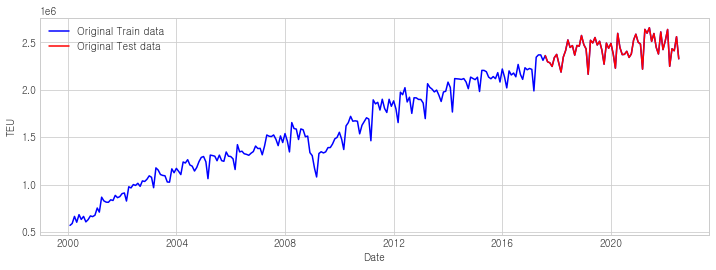

In [9]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(data['TEU'], 'blue', label='Original Train data')
plt.plot(test_data, 'red', label='Original Test data')
plt.legend()

### 2. 다변량 LSTM

In [10]:
import tensorflow 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense,Flatten,Dropout,GRU,Bidirectional,RepeatVector,TimeDistributed

In [11]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [12]:
import random
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [13]:
tf.random.uniform([1]).numpy()

array([0.5380393], dtype=float32)

In [14]:
raw_df = data

In [16]:
split = -78
train = raw_df[0:split] 
test = raw_df[split:] 

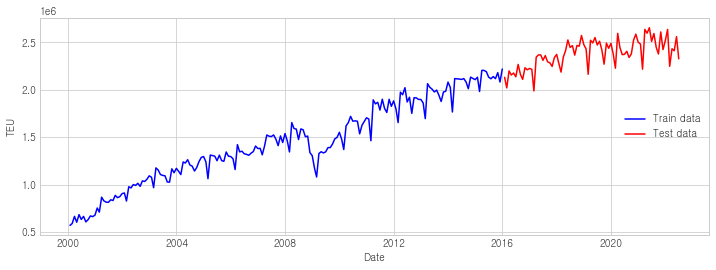

In [17]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(train['TEU'], 'blue', label='Train data')
plt.plot(test['TEU'], 'red', label='Test data')
plt.legend(loc=5)

In [18]:
len(train),len(test)

(192, 78)

In [19]:
data.columns

Index(['TEU', 'BDI', 'ln(HRCI)', 'ln(SCFI)', 'ln(다우존스지수)', '전산업생산지수', '경상수지',
       '환율', '화물수송총괄', '수출물가지수'],
      dtype='object')

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scale_cols =  ['TEU']
scaled_train = scaler.fit_transform(train[scale_cols])  
scaled_train = pd.DataFrame(scaled_train, columns=scale_cols)

feature_train = scaled_train                       # X_train 다변량 시계열 변수 
label_train = scaled_train[['TEU']]               #  y_train 종속변수 

scaled_test = scaler.fit_transform(test[scale_cols]) 
scaled_test = pd.DataFrame(scaled_test, columns=scale_cols)

feature_test = scaled_test                       # X_test 다변량 시계열 변수 
label_test = scaled_test[['TEU']]               #  y_test종속변수 

In [21]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [22]:
window_size = 18 # Input Sequence (입력 길이) : X1,X2,....XT 
n_step_out = 12   # Output Sequence (출력 길이) : Y1,Y2,....YT

### 1. X_train, Y_train 배열

In [23]:
X_train,y = split_sequence(feature_train, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_train = split_sequence(label_train, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [24]:
X_train.shape,Y_train.shape

((163, 18, 1), (163, 12, 1))

### 2. X_test,Y_test 배열

In [25]:
X_test,y = split_sequence(feature_test, window_size, n_step_out) # feature_test= X 다변량 변수 
x, Y_test = split_sequence(label_test, window_size, n_step_out) # label_test= Y 종속변수 예측값 

In [26]:
X_test.shape,Y_test.shape

((49, 18, 1), (49, 12, 1))

In [27]:
class MCDropout(Dropout): # 몬테카를로 드롭아웃 
    def call(self, inputs):
        return super().call(inputs, training=True)

In [28]:
model = Sequential() # Encoder & Decoder

## Encoder state
model.add(Conv1D(filters=48, kernel_size=2,activation='tanh',input_shape=(X_train.shape[1], X_train.shape[2]),padding='causal',name='extractor'))
model.add(MCDropout(0.8))
model.add(Dense(1))
model.add(Flatten())
model.add(RepeatVector(12)) # 출력 개수만큼 반복 

## Decoder State
model.add(LSTM(66, activation='tanh', return_sequences=True)) # Decoder State 
model.add(MCDropout(0.8))
model.add(TimeDistributed(Dense(8,activation='relu'))) 
model.add(TimeDistributed(Dense(1)))

model.compile(loss='mean_squared_error', optimizer='adam',metrics='mae')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, Y_train, epochs= 200, batch_size=10, validation_split=0.02,callbacks=[early_stop])

Epoch 1/200
16/16 [==============================] - 3s 49ms/step - loss: 0.3167 - mae: 0.5032 - val_loss: 0.3375 - val_mae: 0.4948
Epoch 2/200
16/16 [==============================] - 0s 13ms/step - loss: 0.1356 - mae: 0.2893 - val_loss: 0.2295 - val_mae: 0.4108
Epoch 3/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0831 - mae: 0.2235 - val_loss: 0.2102 - val_mae: 0.3930
Epoch 4/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0724 - mae: 0.2105 - val_loss: 0.1363 - val_mae: 0.3090
Epoch 5/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0592 - mae: 0.1887 - val_loss: 0.1500 - val_mae: 0.3259
Epoch 6/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0515 - mae: 0.1772 - val_loss: 0.1181 - val_mae: 0.2948
Epoch 7/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0431 - mae: 0.1594 - val_loss: 0.1280 - val_mae: 0.3051
Epoch 8/200
16/16 [==============================] - 0s 12ms/step - loss: 0.

In [29]:
rcParams['figure.figsize'] = 12, 4

<AxesSubplot:>

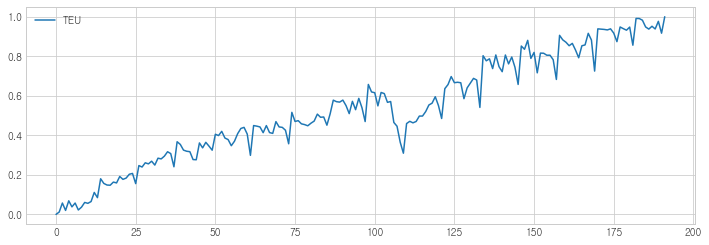

In [30]:
label_train.plot()

<AxesSubplot:>

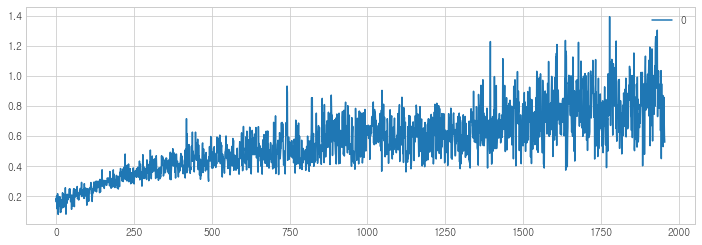

In [31]:
pd.DataFrame(model.predict(X_train).reshape(-1,1)).plot()

#### Most Probable Explanation

### 1. 2017.07 ~ 2018.06

In [32]:
X_test_1 = np.array(feature_test.head(18)).reshape((1, 18, 1)) 

In [33]:
model_MC=  model
prediction = [model_MC.predict(X_test_1) for sample in range(30)]

In [34]:
dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,1, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    #model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)

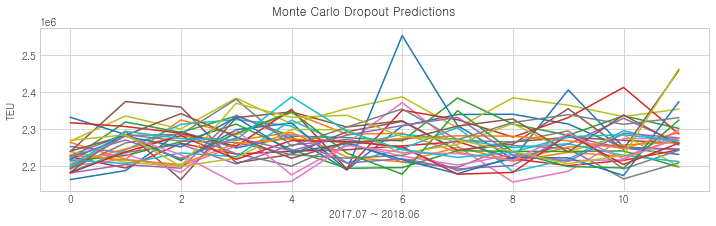

In [35]:
rcParams['figure.figsize'] = 12, 3
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2017.07 ~ 2018.06')
plt.ylabel('TEU')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [36]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])

In [37]:
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [38]:
np.mean(df.std()/df.mean())

0.020634155720472336

In [39]:
rmse = math.sqrt(mean_squared_error(trend[0:12].reset_index()['TEU_Trend'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[0:12].reset_index()['TEU_Trend']- df.transpose().mean())/ trend[0:12].reset_index()['TEU_Trend'])*100) )

RMSE: 85580.81997962178
MAPE: 3.3434692386827756


In [40]:
rmse = math.sqrt(mean_squared_error(trend[0:12].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[0:12].reset_index()['TEU_Trend']- df.transpose().median())/ trend[0:12].reset_index()['TEU_Trend'])*100) )

RMSE: 91878.42923838936
MAPE: 3.539288845327613


In [41]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[:12]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-31,2164218.5,2264708.5,2218182.25,2225700.5,2253520.5,2239657.25,2201190.25,2192664.25,2267811.75,2184387.0,2332515.5,2206519.75,2214544.25,2317901.0,2182114.5,2183453.25,2224014.25,2229907.25,2240213.5,2217746.25,2219308.0,2231480.75,2194365.0,2182296.25,2226245.5,2240909.5,2205508.0,2195716.75,2270221.0,2200276.25


In [42]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:222]
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2018-06-30,2443990,1385,2.926085,2.901474,4.385095,110.3,7980.1,1092.8,137274768,103.55


Mean RMSE: 118220.83539827328
Mean MAPE: 3.9932588794658126


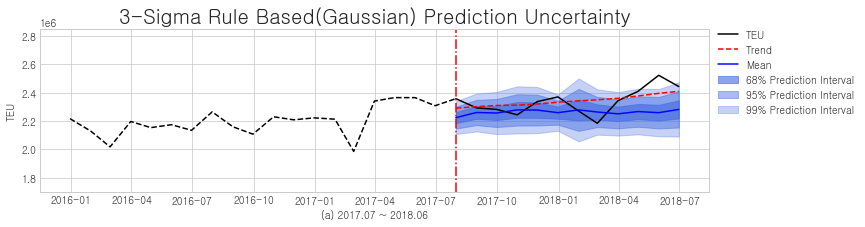

In [43]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2018.06')
plt.ylabel('TEU')
plt.title('3-Sigma Rule Based(Gaussian) Prediction Uncertainty',fontsize=20)
plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[191:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:222], 'black', label='TEU')
plt.plot(trend.head(12),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='royalblue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='royalblue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='royalblue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- df.transpose().mean())/ test_data.head(12).reset_index()['TEU'])*100) )

In [43]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(12).reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.head(12).reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.5833333333333334
추세 변동에 대한 포함확률: 0.3333333333333333


Median RMSE: 123276.4535940313
Median MAPE: 4.0887241956119595


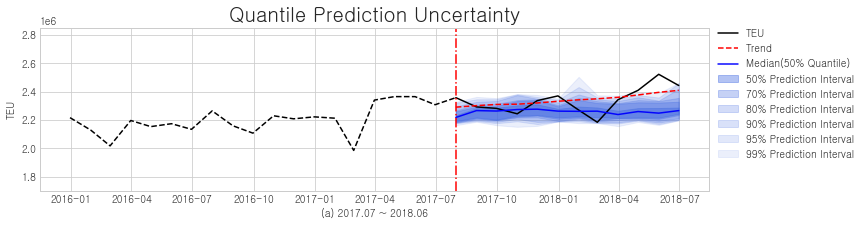

In [44]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2018.06')
plt.ylabel('TEU')
plt.title('Quantile Prediction Uncertainty',fontsize=20)
plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[191:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:222], 'black', label='TEU')
plt.plot(trend.head(12),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue',alpha=10.0)
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='royalblue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='royalblue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='royalblue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='royalblue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='royalblue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='royalblue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.head(12).reset_index()['TEU'])*100) )

In [45]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(12).reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.head(12).reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.6666666666666666
추세 변동에 대한 포함확률: 0.16666666666666666


In [46]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 105951.664
Quantile 70% Interval Sharpness 102014.046875


In [47]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 211903.42
Quantile 95% Interval Sharpness 185545.1421874999
Min Max Interval Sharpness 226232.8


In [48]:
import CRPS.CRPS as pscore

In [49]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.head(12).reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

113885.78750000002
19021.93833333333
15749.301666666668
20653.01111111111
35512.41722222222
87783.53333333333
14506.517500000002
50457.60694444444
67803.58138888888
113370.26999999999
233285.41999999998
132084.06722222222


In [50]:
a = np.array([113885.78750000002,
19021.93833333333,
15749.301666666668,
20653.01111111111,
35512.41722222222,
87783.53333333333,
14506.517500000002,
50457.60694444444,
67803.58138888888,
113370.26999999999,
233285.41999999998,
132084.06722222222])

In [51]:
np.mean(a)

75342.78768518519

In [44]:
class MLE():
    def __init__(self, samples, m, std, learning_rate, epochs, verbose=False):
        """
        :param samples: samples for get MLE
        :param learning_rate: alpha on weight update
        :param epochs: training epochs
        :param verbose: print status
        """
        self._samples = samples
        self._m = m
        self._std = std
        self._learning_rate = learning_rate
        self._epochs = epochs
        self._verbose = verbose


    def likelihood(self, x, M):
        """
        Probability Density Function is Normal distribution
        PDF's y is same as likelihood

        :param x:
        :return: likelihood of input x (likelihood of input x is same as y of pdf)
        """
        return (1 / math.sqrt(2*math.pi) * math.pow(self._std, 2)) * np.exp(-(np.power(x - M, 2) / (2*math.pow(self._std, 2))))


    def fit(self):
        """
        training estimator
        M, which minimizes Likelihood, is obtained by the gradient descent method.
        M is the MLE of the samples
        """

        # init M
        self._estimator = np.random.normal(self._m, self._std, 1)

        # train while epochs
        self._training_process = []
        for epoch in range(self._epochs):
            likelihood = np.prod(self.likelihood(self._samples, self._m))
            prediction = np.prod(self.likelihood(self._samples, self._estimator))
            cost = self.cost(likelihood, prediction)
            self._training_process.append((epoch, cost))
            self.update(self._samples, self._estimator)

            # print status
            if self._verbose == True and ((epoch + 1) % 10 == 0):
                print("Iteration: %d ; cost = %.4f" % (epoch + 1, cost))


    def cost(self, likelihood, prediction):
        """
        cost function
        :param likelihood: likelihood of population
        :param prediction: likelihood in samples
        :return: the cost of optimizing the parameters
        """
        return math.sqrt(likelihood - prediction)


    def update(self, x, M):
        """
        update in gradient descent
        gradient is approximated
        :param x: samples
        :param M: estimator
        """
        gradient = np.sum(np.exp(-(np.power(x - M, 2) / (2*math.pow(self._std, 2)))))
        if self._m > self._estimator:
            self._estimator += self._learning_rate * gradient
        else:
            self._estimator -= self._learning_rate * gradient


    def get_mle(self):
        """
        parameter getter
        :return: estimator of MLE
        """
        return self._estimator

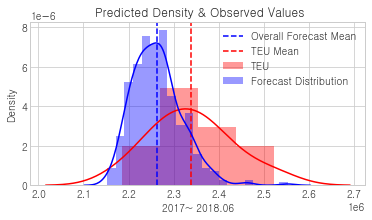

In [46]:
plt.figure(figsize=(6,3))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=df.transpose().mean().mean(), color='blue',linestyle='dashed',label='Overall Forecast Mean')
plt.axvline(x=test_data.head(12).mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.head(12).reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2017~ 2018.06')
plt.legend()

In [47]:
# run example
if __name__ == "__main__":

    # samples for MLE
    samples = np.array(df)

    # assumptions about the population
    mean = np.array([df.transpose().mean().mean()])
    std = df.transpose().mean().std()

    # get MLE
    estimator = MLE(samples, mean, std, learning_rate=0.1, epochs=30)
    estimator.fit()
    result = estimator.get_mle()
    print(result)

[2270776.09951489]


In [49]:
def KL(p,q):
    return(np.abs(sum(p*np.log(p/q))))

In [50]:
for i in range(0,30):
    print(KL(df[i],test_data.head(12).reset_index()['TEU']))

860288.4030202151
816117.7726985535
416828.4117823824
1203204.2364876764
1036967.3525654117
676619.351856872
1066822.4532465583
1270894.4375577294
48724.69441533435
913517.080755447
381040.8791191444
1044773.7197673811
1185841.5267664029
336766.1365704654
1217559.5656952516
518212.088366832
1242704.0432460909
1016005.0677105801
1018097.4946659
1037147.1723878747
1035908.689603435
924408.804738963
950917.2205207238
1187339.5391150615
847769.8345320642
654023.3212604172
1253409.3442085227
398602.2572150521
538873.8762591787
766212.0154758575


In [51]:
a = np.array([860288.4030202151,
816117.7726985535,
416828.4117823824,
1203204.2364876764,
1036967.3525654117,
676619.351856872,
1066822.4532465583,
1270894.4375577294,
48724.69441533435,
913517.080755447,
381040.8791191444,
1044773.7197673811,
1185841.5267664029,
336766.1365704654,
1217559.5656952516,
518212.088366832,
1242704.0432460909,
1016005.0677105801,
1018097.4946659,
1037147.1723878747,
1035908.689603435,
924408.804738963,
950917.2205207238,
1187339.5391150615,
847769.8345320642,
654023.3212604172,
1253409.3442085227,
398602.2572150521,
538873.8762591787,
766212.0154758575])

In [52]:
np.mean(a)

862186.5597203794

### 2. 2018.07 ~ 2019.06

In [53]:
X_test_2 = np.array(feature_test[12:30]).reshape((1, 18, 1)) 

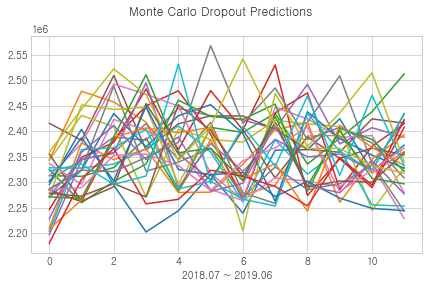

In [54]:
model_MC=  model
prediction = [model_MC.predict(X_test_2) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,1, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    #model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 7, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2018.07 ~ 2019.06')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [55]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [56]:
np.mean(df.std()/df.mean())

0.028351757675409317

In [57]:
rmse = math.sqrt(mean_squared_error(trend[12:24].reset_index()['TEU_Trend'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[12:24].reset_index()['TEU_Trend']- df.transpose().mean())/ trend[12:24].reset_index()['TEU_Trend'])*100) )

RMSE: 89094.23249352971
MAPE: 3.546326980287761


In [58]:
rmse = math.sqrt(mean_squared_error(trend[12:24].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[12:24].reset_index()['TEU_Trend']- df.transpose().median())/ trend[12:24].reset_index()['TEU_Trend'])*100) )

RMSE: 91945.50418658939
MAPE: 3.625374197904538


In [59]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[12:24]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-31,2295137.75,2343252.25,2312838.25,2284584.0,2196916.75,2415559.75,2312087.0,2302761.75,2342718.25,2328177.75,2270960.5,2209665.75,2324990.5,2245713.75,2273230.25,2355399.75,2336520.5,2285444.75,2269649.25,2203109.0,2300926.0,2207704.25,2271090.5,2179917.25,2227338.25,2278243.75,2284093.75,2286793.75,2358665.0,2322060.5


In [60]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:234]
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2019-06-30,2469920,1354,2.840263,2.897122,4.424881,109.8,6166.1,1175.62,140568904,100.79


Mean RMSE: 143834.61139132595
Mean MAPE: 5.386205433871535


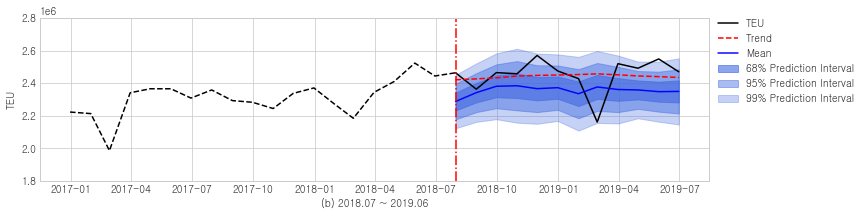

In [61]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2018.07 ~ 2019.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[203:223], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[222:234], 'black', label='TEU')
plt.plot(trend.iloc[12:24],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2018-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='royalblue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='royalblue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='royalblue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[12:24].reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.iloc[12:24].reset_index()['TEU']- df.transpose().mean())/ test_data.iloc[12:24].reset_index()['TEU'])*100) )

In [61]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[12:24].reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[12:24].reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.5
추세 변동에 대한 포함확률: 0.16666666666666666


Median RMSE: 149138.60461259843
Median MAPE: 5.584372960040388


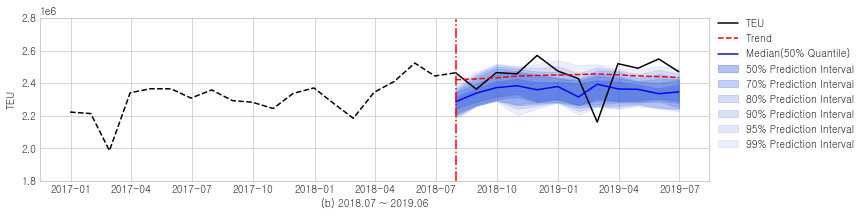

In [62]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2018.07 ~ 2019.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[203:223], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[222:234], 'black', label='TEU')
plt.plot(trend.iloc[12:24],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue',alpha=10.0)
plt.axvline(x='2018-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='royalblue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='royalblue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='royalblue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='royalblue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='royalblue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='royalblue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[12:24].reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.iloc[12:24].reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.iloc[12:24].reset_index()['TEU'])*100) )

In [63]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[12:24].reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[12:24].reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.4166666666666667
추세 변동에 대한 포함확률: 0.16666666666666666


In [64]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 133669.05
Quantile 70% Interval Sharpness 138153.02916666676


In [65]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[12:24].reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.5833333333333334


In [66]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 267338.1
Quantile 95% Interval Sharpness 221231.64322916654
Min Max Interval Sharpness 269464.47


In [67]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.iloc[12:24].reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

146168.635
18924.108888888888
56612.18916666666
41224.347222222226
163482.2772222222
71716.75333333334
59462.72138888888
174269.3102777778
119172.93777777777
102403.97888888887
167751.1113888889
85730.17666666667


In [68]:
a = np.array([146168.635,
18924.108888888888,
56612.18916666666,
41224.347222222226,
163482.2772222222,
71716.75333333334,
59462.72138888888,
174269.3102777778,
119172.93777777777,
102403.97888888887,
167751.1113888889,
85730.17666666667])

In [69]:
np.mean(a)

100576.54560185185

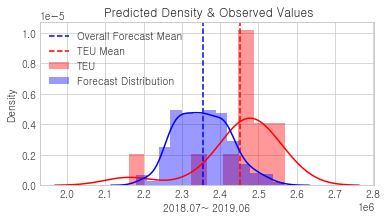

In [62]:
plt.figure(figsize=(6,3))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=df.transpose().mean().mean(), color='blue',linestyle='dashed',label='Overall Forecast Mean')
plt.axvline(x=test_data.iloc[12:24].mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.iloc[12:24].reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2018.07~ 2019.06')
plt.legend(loc=2)

In [63]:
# run example
if __name__ == "__main__":

    # samples for MLE
    samples = np.array(df)

    # assumptions about the population
    mean = np.array([df.transpose().mean().mean()])
    std = df.transpose().mean().std()

    # get MLE
    estimator = MLE(samples, mean, std, learning_rate=0.1, epochs=30)
    estimator.fit()
    result = estimator.get_mle()
    print(result)

[2324070.13241668]


In [64]:
for i in range(0,30):
    print(KL(df[i],test_data.iloc[12:24].reset_index()['TEU']))

1485912.3527812704
969928.2546098228
822200.0919123658
861147.7252734145
695744.7452906064
468512.55675024586
745590.7701834007
1140035.1894437494
914355.4794034631
1381168.177616372
938275.370583137
1321731.1856131773
972288.3473948735
783242.8449488267
1049062.9993569416
1175037.9990829898
1508076.0132181556
1286270.877090452
693000.672343367
1351061.0450608612
1597601.8663524673
1280286.3020214655
1147504.841306769
1700517.7056232912
1417044.0552839004
1385006.1524908852
1358624.917429952
749004.4868478678
475178.5035571421
952165.8367779059


In [65]:
a = np.array([1485912.3527812704,
969928.2546098228,
822200.0919123658,
861147.7252734145,
695744.7452906064,
468512.55675024586,
745590.7701834007,
1140035.1894437494,
914355.4794034631,
1381168.177616372,
938275.370583137,
1321731.1856131773,
972288.3473948735,
783242.8449488267,
1049062.9993569416,
1175037.9990829898,
1508076.0132181556,
1286270.877090452,
693000.672343367,
1351061.0450608612,
1597601.8663524673,
1280286.3020214655,
1147504.841306769,
1700517.7056232912,
1417044.0552839004,
1385006.1524908852,
1358624.917429952,
749004.4868478678,
475178.5035571421,
952165.8367779059])

In [66]:
np.mean(a)

1087519.2455216378

### 3. 2019.07 ~ 2020.06

In [67]:
X_test_3 = np.array(feature_test[24:42]).reshape((1, 18, 1)) 

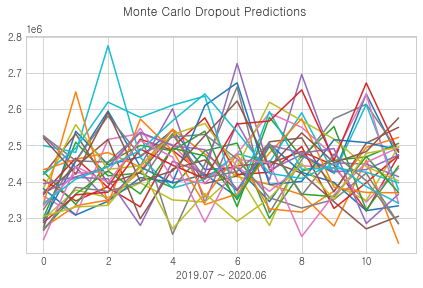

In [68]:
model_MC=  model
prediction = [model_MC.predict(X_test_3) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,1, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    #model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 7, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2019.07 ~ 2020.06')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [69]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [70]:
np.mean(df.std()/df.mean())

0.03613325208425522

In [71]:
rmse = math.sqrt(mean_squared_error(trend[24:36].reset_index()['TEU_Trend'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[24:36].reset_index()['TEU_Trend']- df.transpose().mean())/ trend[24:36].reset_index()['TEU_Trend'])*100) )

RMSE: 36929.97774315592
MAPE: 1.2438312360770178


In [72]:
rmse = math.sqrt(mean_squared_error(trend[24:36].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[24:36].reset_index()['TEU_Trend']- df.transpose().median())/ trend[24:36].reset_index()['TEU_Trend'])*100) )

RMSE: 36395.81797376749
MAPE: 1.1932261838126934


In [76]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[24:36]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-31,2271953.25,2272041.25,2299768.0,2404987.0,2525746.25,2419577.75,2359846.25,2322487.5,2296216.5,2499427.5,2291621.5,2432800.25,2427269.75,2368352.0,2368755.75,2364295.5,2333438.0,2526571.5,2381271.5,2419650.5,2380142.0,2337747.0,2266587.5,2286207.25,2393969.25,2520352.0,2238790.5,2264349.75,2303320.25,2339812.0


In [77]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:246]
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2020-06-30,2371415,1799,2.70092,2.992441,4.411836,110.4,7039.3,1210.01,116998896,95.01


Mean RMSE: 107178.53152074211
Mean MAPE: 3.589700484385673


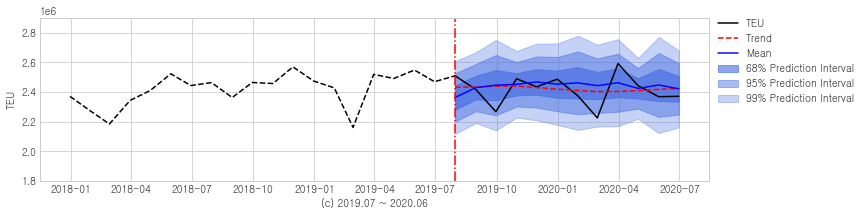

In [78]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(c) 2019.07 ~ 2020.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.8e6,2.9e6)
plt.plot(data['TEU'].iloc[215:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:246], 'black', label='TEU')
plt.plot(trend.iloc[24:36],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='royalblue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='royalblue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='royalblue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[24:36].reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.iloc[24:36].reset_index()['TEU']- df.transpose().mean())/ test_data.iloc[24:36].reset_index()['TEU'])*100) )

In [79]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[24:36].reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[24:36].reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.9166666666666666
추세 변동에 대한 포함확률: 1.0


Median RMSE: 106213.96077814343
Median MAPE: 3.6672346304073637


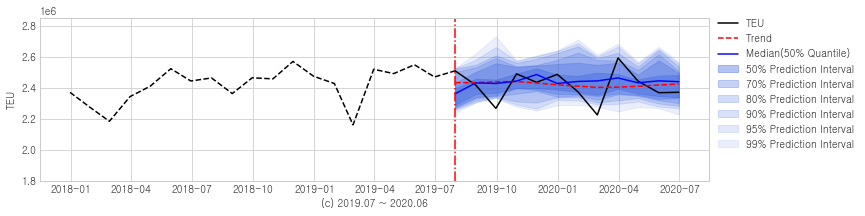

In [80]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(c) 2019.07 ~ 2020.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
plt.ylim(1.8e6,2.85e6)
plt.plot(data['TEU'].iloc[215:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:246], 'black', label='TEU')
plt.plot(trend.iloc[24:36],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue',alpha=10.0)
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='royalblue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='royalblue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='royalblue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='royalblue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='royalblue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='royalblue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[24:36].reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.iloc[24:36].reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.iloc[24:36].reset_index()['TEU'])*100) )

In [81]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[24:36].reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[24:36].reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.8333333333333334
추세 변동에 대한 포함확률: 0.9166666666666666


In [82]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 179102.25
Quantile 70% Interval Sharpness 179060.71562500004


In [83]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[24:36].reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.8333333333333334


In [84]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 358204.5
Quantile 95% Interval Sharpness 313037.97656249994
Min Max Interval Sharpness 362934.1


In [85]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.iloc[24:36].reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

103505.15444444444
18816.136666666665
126600.28444444443
24346.825833333332
29356.714444444446
31401.236111111113
44397.62222222223
166182.88638888887
87046.34333333334
17081.592222222225
44927.21944444445
35528.20333333334


In [86]:
a = np.array([103505.15444444444,
18816.136666666665,
126600.28444444443,
24346.825833333332,
29356.714444444446,
31401.236111111113,
44397.62222222223,
166182.88638888887,
87046.34333333334,
17081.592222222225,
44927.21944444445,
35528.20333333334])

In [87]:
np.mean(a)

60765.85157407408

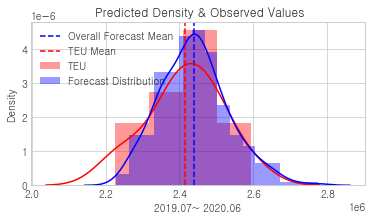

In [73]:
plt.figure(figsize=(6,3))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=df.transpose().mean().mean(), color='blue',linestyle='dashed',label='Overall Forecast Mean')
plt.axvline(x=test_data.iloc[24:36].mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.iloc[24:36].reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2019.07~ 2020.06')
plt.legend(loc=2)

In [74]:
# run example
if __name__ == "__main__":

    # samples for MLE
    samples = np.array(df)

    # assumptions about the population
    mean = np.array([df.transpose().mean().mean()])
    std = df.transpose().mean().std()

    # get MLE
    estimator = MLE(samples, mean, std, learning_rate=0.1, epochs=30)
    estimator.fit()
    result = estimator.get_mle()
    print(result)

[2479784.64304187]


In [76]:
for i in range(0,30):
    print(KL(df[i],test_data.iloc[24:36].reset_index()['TEU']))

551044.9541248062
398853.07292892784
229912.63956069615
212178.29263228457
721979.4775031586
38445.14607007464
156035.7186400619
657018.0690959713
418576.41475323855
1042239.4455262718
10603.532925457854
282800.4478171242
495200.56365525175
202568.6362704626
386606.57059756794
418010.68242039776
682910.738539087
354368.97868478764
965357.7455262112
1086827.4243333477
496885.46968158055
315088.7860447833
131384.750747948
841222.8637154932
317654.9169327744
1070543.1828480149
95206.9951090794
117136.85063039223
485112.1488572939
486601.94200832077


In [77]:
a = np.array([551044.9541248062,
398853.07292892784,
229912.63956069615,
212178.29263228457,
721979.4775031586,
38445.14607007464,
156035.7186400619,
657018.0690959713,
418576.41475323855,
1042239.4455262718,
10603.532925457854,
282800.4478171242,
495200.56365525175,
202568.6362704626,
386606.57059756794,
418010.68242039776,
682910.738539087,
354368.97868478764,
965357.7455262112,
1086827.4243333477,
496885.46968158055,
315088.7860447833,
131384.750747948,
841222.8637154932,
317654.9169327744,
1070543.1828480149,
95206.9951090794,
117136.85063039223,
485112.1488572939,
486601.94200832077])

In [78]:
np.mean(a)

455612.5486060289

### 4. 2020.07 ~ 2021.06

In [79]:
X_test_4 = np.array(feature_test[36:54]).reshape((1, 18, 1)) 

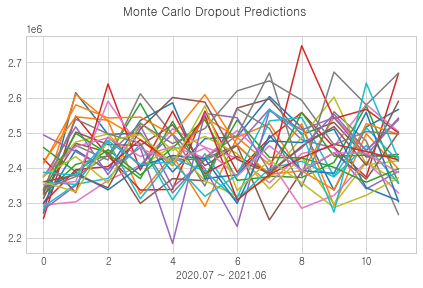

In [80]:
model_MC=  model
prediction = [model_MC.predict(X_test_4) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,1, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    #model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 7, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2020.07 ~ 2021.06')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [81]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [82]:
np.mean(df.std()/df.mean())

0.03575463965535164

In [83]:
rmse = math.sqrt(mean_squared_error(trend[36:48].reset_index()['TEU_Trend'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[36:48].reset_index()['TEU_Trend']- df.transpose().mean())/ trend[36:48].reset_index()['TEU_Trend'])*100) )

RMSE: 47055.03205761137
MAPE: 1.6575389079917022


In [84]:
rmse = math.sqrt(mean_squared_error(trend[36:48].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[36:48].reset_index()['TEU_Trend']- df.transpose().median())/ trend[36:48].reset_index()['TEU_Trend'])*100) )

RMSE: 55748.56904078684
MAPE: 1.9852314957431887


In [94]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[36:48]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-31,2270776.75,2325205.0,2323614.0,2255357.0,2373564.5,2329730.75,2294427.75,2375712.5,2374604.0,2289123.5,2298462.25,2416700.5,2457949.5,2425836.75,2280682.75,2312852.5,2377706.0,2340244.5,2376017.0,2359114.0,2337743.75,2411874.25,2335666.5,2299328.0,2493711.0,2360038.0,2352042.25,2338743.75,2358773.5,2387163.0


In [95]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:258]
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2021-06-30,2507761,3383,3.40973,3.569689,4.537851,117.6,8830.5,1121.3,130920264,107.4


Mean RMSE: 130561.61198122293
Mean MAPE: 4.635111977534172


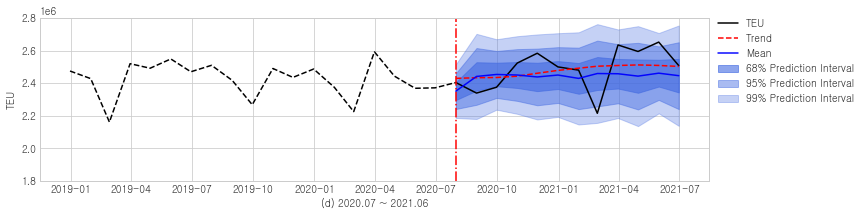

In [96]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(d) 2020.07 ~ 2021.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[227:247], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[246:258], 'black', label='TEU')
plt.plot(trend.iloc[36:48],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2020-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='royalblue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='royalblue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='royalblue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[36:48].reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.iloc[36:48].reset_index()['TEU']- df.transpose().mean())/ test_data.iloc[36:48].reset_index()['TEU'])*100) )

In [97]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[36:48].reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[36:48].reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.8333333333333334
추세 변동에 대한 포함확률: 0.9166666666666666


Median RMSE: 129208.7870811896
Median MAPE: 4.650353194487047


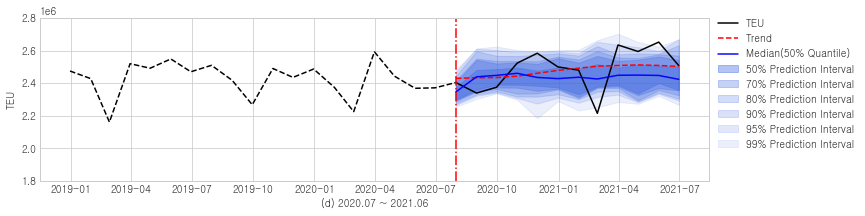

In [98]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(d) 2020.07 ~ 2021.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[227:247], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[246:258], 'black', label='TEU')
plt.plot(trend.iloc[36:48],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue',alpha=10.0)
plt.axvline(x='2020-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='royalblue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='royalblue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='royalblue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='royalblue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='royalblue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='royalblue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[36:48].reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.iloc[36:48].reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.iloc[36:48].reset_index()['TEU'])*100) )

In [99]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[36:48].reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[36:48].reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.8333333333333334
추세 변동에 대한 포함확률: 0.9166666666666666


In [100]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 172987.17
Quantile 70% Interval Sharpness 175575.94270833334


In [101]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[36:48].reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.8333333333333334


In [102]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 345974.4
Quantile 95% Interval Sharpness 296141.6885416666
Min Max Interval Sharpness 357220.84


In [103]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.iloc[36:48].reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

35413.119444444455
57066.59611111111
45732.7938888889
41424.89527777778
99958.57611111112
37627.57305555556
31005.2375
188408.3877777778
136041.17333333337
99772.6511111111
144719.81583333333
42505.17083333333


In [104]:
a = np.array([35413.119444444455,
57066.59611111111,
45732.7938888889,
41424.89527777778,
99958.57611111112,
37627.57305555556,
31005.2375,
188408.3877777778,
136041.17333333337,
99772.6511111111,
144719.81583333333,
42505.17083333333])

In [105]:
np.mean(a)

79972.9991898148

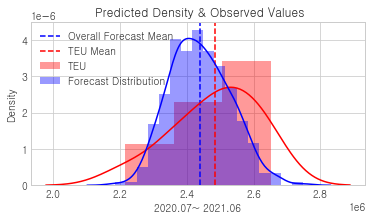

In [85]:
plt.figure(figsize=(6,3))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=df.transpose().mean().mean(), color='blue',linestyle='dashed',label='Overall Forecast Mean')
plt.axvline(x=test_data.iloc[36:48].mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.iloc[36:48].reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2020.07~ 2021.06')
plt.legend(loc=2)

In [86]:
# run example
if __name__ == "__main__":

    # samples for MLE
    samples = np.array(df)

    # assumptions about the population
    mean = np.array([df.transpose().mean().mean()])
    std = df.transpose().mean().std()

    # get MLE
    estimator = MLE(samples, mean, std, learning_rate=0.1, epochs=30)
    estimator.fit()
    result = estimator.get_mle()
    print(result)

[2431142.79598674]


In [87]:
for i in range(0,30):
    print(KL(df[i],test_data.iloc[36:48].reset_index()['TEU']))

48782.589944512816
274608.54848869186
605837.1702178114
326873.1712994538
477051.1425639015
397725.6053673683
676111.0501577738
297117.49658976466
582556.4954087635
818060.744187322
629709.8397825586
216288.43786553547
504405.174675237
129034.14092043808
501830.39351727284
676248.2571280808
807187.2442542012
345809.1806242663
841523.4766592905
1110615.1811295846
989290.9298731341
22666.13585588678
645427.353203244
769567.411071467
286957.68915175647
214103.17778639542
616359.7252088214
228290.881808425
980186.1220512104
564084.3902702498


In [88]:
a = np.array([48782.589944512816,
274608.54848869186,
605837.1702178114,
326873.1712994538,
477051.1425639015,
397725.6053673683,
676111.0501577738,
297117.49658976466,
582556.4954087635,
818060.744187322,
629709.8397825586,
216288.43786553547,
504405.174675237,
129034.14092043808,
501830.39351727284,
676248.2571280808,
807187.2442542012,
345809.1806242663,
841523.4766592905,
1110615.1811295846,
989290.9298731341,
22666.13585588678,
645427.353203244,
769567.411071467,
286957.68915175647,
214103.17778639542,
616359.7252088214,
228290.881808425,
980186.1220512104,
564084.3902702498])

In [89]:
np.mean(a)

519476.97190208064

### 5. 2021.07 ~ 2022.06

In [90]:
X_test_5 = np.array(feature_test[48:66]).reshape((1, 18, 1)) 

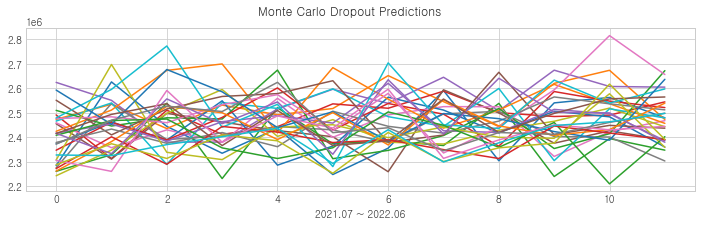

In [91]:
model_MC=  model
prediction = [model_MC.predict(X_test_5) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,1, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    #model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 12, 3
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2021.07 ~ 2022.06')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [92]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [93]:
np.mean(df.std()/df.mean())

0.037219397723674774

In [94]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[48:60]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-31,2285227.5,2473845.25,2261451.5,2491707.25,2624738.25,2455894.0,2459682.25,2275713.25,2243396.5,2466795.75,2373881.5,2424941.75,2510430.75,2347758.25,2417517.75,2551783.25,2477073.5,2379292.25,2307751.75,2479596.0,2593315.75,2262418.0,2408718.5,2272708.75,2416527.5,2416035.5,2306124.75,2372660.25,2288230.5,2328225.0


In [95]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2022-06-30,2324505,2240,3.749211,3.625297,4.488265,120.1,5609.8,1277.35,118631016,132.61


In [96]:
rmse = math.sqrt(mean_squared_error(trend.tail(12).reset_index()['TEU_Trend'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend.tail(12).reset_index()['TEU_Trend']- df.transpose().mean())/ trend.tail(12).reset_index()['TEU_Trend'])*100) )

RMSE: 50703.19108168957
MAPE: 1.7345496734330341


In [97]:
rmse = math.sqrt(mean_squared_error(trend.tail(12).reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend.tail(12).reset_index()['TEU_Trend']- df.transpose().median())/ trend.tail(12).reset_index()['TEU_Trend'])*100) )

RMSE: 53791.78675660935
MAPE: 1.9640977581897392


Mean RMSE: 122054.05991442378
Mean MAPE: 4.2192167628209365


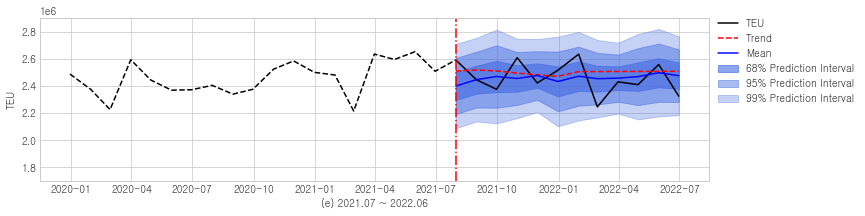

In [114]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(e) 2021.07 ~ 2022.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.7e6,2.9e6)
plt.plot(data['TEU'].iloc[239:259], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[258:270], 'black', label='TEU')
plt.plot(trend.iloc[48:60],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2021-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='royalblue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='royalblue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='royalblue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.tail(12).reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.tail(12).reset_index()['TEU']- df.transpose().mean())/ test_data.tail(12).reset_index()['TEU'])*100) )

In [115]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(12).reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.tail(12).reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.9166666666666666
추세 변동에 대한 포함확률: 0.9166666666666666


Median RMSE: 121904.69359697089
Median MAPE: 4.155210111341297


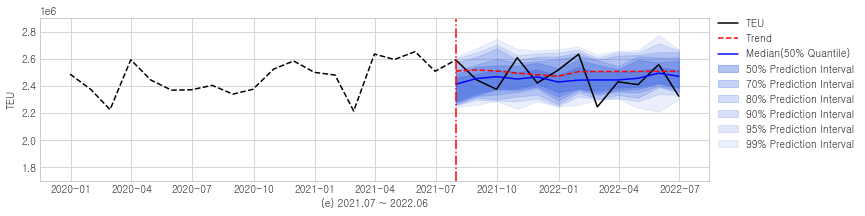

In [116]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(e) 2021.07 ~ 2022.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
plt.ylim(1.7e6,2.9e6)
plt.plot(data['TEU'].iloc[239:259], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[258:270], 'black', label='TEU')
plt.plot(trend.iloc[48:60],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue',alpha=10.0)
plt.axvline(x='2021-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='royalblue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='royalblue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='royalblue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='royalblue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='royalblue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='royalblue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.tail(12).reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.tail(12).reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.tail(12).reset_index()['TEU'])*100) )

In [117]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(12).reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.tail(12).reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.8333333333333334
추세 변동에 대한 포함확률: 0.9166666666666666


In [118]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 202709.95
Quantile 70% Interval Sharpness 192148.11875000005


In [119]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(12).reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.9166666666666666


In [120]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 405420.0
Quantile 95% Interval Sharpness 351257.5203125
Min Max Interval Sharpness 429589.34


In [121]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.iloc[48:60].reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

136542.95861111113
24242.234722222223
49548.12833333333
105847.9636111111
31117.949166666665
53500.650833333326
108102.27111111111
154248.12277777778
20520.774166666662
33955.59111111111
39347.64583333333
98034.0452777778


In [122]:
a = np.array([136542.95861111113,
24242.234722222223,
49548.12833333333,
105847.9636111111,
31117.949166666665,
53500.650833333326,
108102.27111111111,
154248.12277777778,
20520.774166666662,
33955.59111111111,
39347.64583333333,
98034.0452777778])

In [123]:
np.mean(a)

71250.69462962964

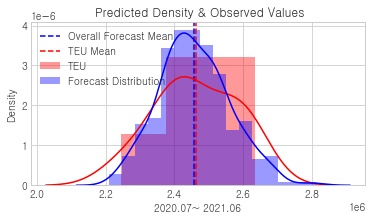

In [98]:
plt.figure(figsize=(6,3))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=df.transpose().mean().mean(), color='blue',linestyle='dashed',label='Overall Forecast Mean')
plt.axvline(x=test_data.iloc[48:60].mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.iloc[48:60].reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2020.07~ 2021.06')
plt.legend(loc=2)

In [99]:
# run example
if __name__ == "__main__":

    # samples for MLE
    samples = np.array(df)

    # assumptions about the population
    mean = np.array([df.transpose().mean().mean()])
    std = df.transpose().mean().std()

    # get MLE
    estimator = MLE(samples, mean, std, learning_rate=0.1, epochs=30)
    estimator.fit()
    result = estimator.get_mle()
    print(result)

[2440537.3812655]


In [101]:
for i in range(0,30):
    print(KL(df[i],test_data.iloc[48:60].reset_index()['TEU']))

233179.2351566587
886776.5447205745
927965.2764475018
343294.56182587077
1160470.3880267404
370658.0042087725
154915.94925258326
513468.4137421008
330894.615320095
268948.3096303628
244174.83953288943
1030996.3931069095
142169.37372477053
267196.84496628656
1762.5273244860437
502376.65241414914
885143.8384241505
89449.46323300977
363572.8772497506
1009745.4277329573
579575.5594063952
162138.76357563396
717362.3224868599
980784.557091346
207064.73219093814
195780.79371431348
407402.95964167995
11733.194106419221
1008092.5627310395
823986.9836044342


In [102]:
a =  np.array([233179.2351566587,
886776.5447205745,
927965.2764475018,
343294.56182587077,
1160470.3880267404,
370658.0042087725,
154915.94925258326,
513468.4137421008,
330894.615320095,
268948.3096303628,
244174.83953288943,
1030996.3931069095,
142169.37372477053,
267196.84496628656,
1762.5273244860437,
502376.65241414914,
885143.8384241505,
89449.46323300977,
363572.8772497506,
1009745.4277329573,
579575.5594063952,
162138.76357563396,
717362.3224868599,
980784.557091346,
207064.73219093814,
195780.79371431348,
407402.95964167995,
11733.194106419221,
1008092.5627310395,
823986.9836044342])

In [103]:
np.mean(a)

494036.06548632256